In [1]:
import pandas as pd

path = "train_clean.jsonl"
path_test = "test_clean.jsonl"

df = pd.read_json(path, lines=True)
df_test = pd.read_json(path_test, lines=True)

In [2]:
TARGET_COL = "label"   # <- change if it has another name

cols_to_drop = [
    "text_clean",
    "user.description",
    "user.location",
    "created_at_dt",
    "in_reply_to_screen_name",
    TARGET_COL,          # we DROP the label from X features
]

# ---- TRAIN (df) ----
meta_cols_train = [c for c in df.columns if c not in cols_to_drop]
df_xgb = df[meta_cols_train].copy()

# ---- TEST (df_t) ----
# Use the *same* columns for test (intersection with df_t just in case)
meta_cols_test = [c for c in meta_cols_train if c in df_test.columns]
df_t_xgb = df_test[meta_cols_test].copy()

# Target
y_all = df[TARGET_COL].values


In [3]:
import pandas as pd

cat_cols = ["source", "user.translator_type", "quoted_status.lang"]

for col in cat_cols:
    if col in df_xgb.columns and col in df_t_xgb.columns:
        # 1) Build union of categories on train + test
        all_cats = pd.concat([df_xgb[col], df_t_xgb[col]], axis=0).astype("category").cat.categories
        
        # 2) Shared CategoricalDtype
        cat_type = pd.api.types.CategoricalDtype(categories=all_cats)
        
        # 3) Apply to BOTH, then take codes
        df_xgb[col]   = df_xgb[col].astype(cat_type).cat.codes
        df_t_xgb[col] = df_t_xgb[col].astype(cat_type).cat.codes


In [4]:
LABEL_COL = "label"
TEXT_COLS = ["text_clean", "user.description", "user.location"]

# --- create text_all in BOTH train and test ---
for d in (df, df_test):
    d["text_all"] = (
        d["text_clean"].fillna("") + " [DESC] " +
        d["user.description"].fillna("") + " [LOC] " +
        d["user.location"].fillna("")
    ).str.strip()

# Train set
texts_train = df["text_all"].astype(str).values
y_all       = df[LABEL_COL].astype(int).values

# Test set
texts_test  = df_test["text_all"].astype(str).values


In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# ----- Basic stuff -----
N_SPLITS = 5  # or 10 if you want, but 5 is standard
RANDOM_STATE = 42

X_meta_all  = df_xgb.values        # already defined
X_meta_test = df_t_xgb.values

X_text_all  = texts_train          # already defined
X_text_test = texts_test

y_all = df[TARGET_COL].astype(int).values

# ----- CV splitter -----
skf = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

# ----- OOF containers -----
# For XGBoost (one prob per sample, binary classification)
oof_xgb = np.zeros(len(df), dtype=float)
test_pred_xgb = np.zeros((len(df_test), N_SPLITS), dtype=float)

# For CamemBERT (we’ll also store probabilities)
oof_cam = np.zeros(len(df), dtype=float)
test_pred_cam = np.zeros((len(df_test), N_SPLITS), dtype=float)

# Later: these two will be stacked as features for the MLP:
# X_meta_level2 = np.column_stack([oof_xgb, oof_cam])


In [10]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd

def modelfit(alg, X_train, y_train, X_valid, y_valid,
             useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """
    Fit an XGBoost model with optional CV to tune n_estimators,
    then train on train set and evaluate on train + valid.
    Also plots CV AUC (if useTrainCV) and feature importance.
    """
    # ---------- STEP 1: CV with DMatrix to pick best n_estimators ----------
    if useTrainCV:
        print("Starting cross-validation with early stopping...")
        xgb_param = alg.get_xgb_params()
        
        # DMatrix for CV
        dtrain = xgb.DMatrix(X_train, label=y_train)
        
        cvresult = xgb.cv(
            params=xgb_param,
            dtrain=dtrain,
            num_boost_round=alg.get_params()['n_estimators'],
            nfold=cv_folds,
            metrics='auc',
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=True
        )
        
        # set best n_estimators
        best_n = cvresult.shape[0]
        alg.set_params(n_estimators=best_n)
        print(f"\nBest number of trees (n_estimators): {best_n}")
        
        # ---- Plot CV AUC over boosting rounds ----
        plt.figure(figsize=(7,4))
        plt.plot(cvresult['train-auc-mean'], label='train AUC')
        plt.plot(cvresult['test-auc-mean'], label='valid AUC')
        plt.xlabel("Boosting round")
        plt.ylabel("AUC")
        plt.title("XGBoost CV AUC")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # ---------- STEP 2: Fit on training set, evaluate on train + valid ----------
    print("\nFitting final model on training data...")
    alg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=True
        # no eval_metric here → already set in constructor
        # you *could* add early_stopping_rounds=50 if your version supports it
    )
    
    # Predictions
    y_train_pred = alg.predict(X_train)
    y_train_proba = alg.predict_proba(X_train)[:, 1]
    
    y_valid_pred = alg.predict(X_valid)
    y_valid_proba = alg.predict_proba(X_valid)[:, 1]
    
    # Metrics
    print("\n=== Model Report (TRAIN) ===")
    print(f"Accuracy : {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"AUC      : {roc_auc_score(y_train, y_train_proba):.4f}")
    
    print("\n=== Model Report (VALID) ===")
    print(f"Accuracy : {accuracy_score(y_valid, y_valid_pred):.4f}")
    print(f"AUC      : {roc_auc_score(y_valid, y_valid_proba):.4f}")
    
    # ---------- STEP 3: Plot feature importance ----------
    booster = alg.get_booster()
    # importance_type can be: 'weight', 'gain', 'cover', etc.
    fmap = booster.get_score(importance_type='gain')
    
    if len(fmap) == 0:
        print("\nNo feature importance found (check model / training).")
        return alg
    
    # sort and keep top 20
    importance_df = pd.DataFrame(
        list(fmap.items()), columns=['feature', 'importance']
    ).sort_values('importance', ascending=False).head(20)
    
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.gca().invert_yaxis()
    plt.xlabel("Gain")
    plt.title("Top 20 Feature Importances (gain)")
    plt.tight_layout()
    plt.show()
    
    return alg


In [11]:
from xgboost import XGBClassifier
best_max_depth = 10
best_min_child_weight = 1
best_gamma = 0

xgb_base_params = dict(
    learning_rate=0.05,
    n_estimators=1000,                # upper bound; CV will pick best
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=1.0,
    reg_alpha=0.1,
    reg_lambda=0.1,
    colsample_bytree=0.6,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda",                    # or remove if no GPU
)


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizerFast, CamembertForSequenceClassification
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")


Using device: cuda


In [16]:
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, max_len=128):
        self.texts = list(texts)
        self.labels = None if labels is None else np.array(labels, dtype=np.int64)
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


In [17]:
def train_camembert_one_fold(
    texts_tr, y_tr,
    texts_val, y_val,
    texts_test,
    epochs=2,
    batch_size=16,
    lr=2e-5,
    max_len=256
):
    # Datasets
    train_ds = TextDataset(texts_tr, y_tr, max_len=max_len)
    val_ds   = TextDataset(texts_val, y_val, max_len=max_len)
    test_ds  = TextDataset(texts_test, labels=None, max_len=max_len)

    # Dataloaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Fresh model for this fold
    model = CamembertForSequenceClassification.from_pretrained(
        "camembert-base",
        num_labels=2
    )
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_auc = 0.0
    best_state_dict = None

    # ----- Training loop -----
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"[Epoch {epoch+1}/{epochs}] Train loss: {avg_train_loss:.4f}")

        # ----- Validation -----
        model.eval()
        val_probs = []
        val_true = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)[:, 1]  # prob of class 1

                val_probs.append(probs.cpu().numpy())
                val_true.append(labels.cpu().numpy())

        val_probs = np.concatenate(val_probs)
        val_true = np.concatenate(val_true)

        from sklearn.metrics import roc_auc_score
        val_auc = roc_auc_score(val_true, val_probs)
        print(f"[Epoch {epoch+1}/{epochs}] Val AUC: {val_auc:.4f}")

        # Keep best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

    print("Best Val AUC for this fold:", best_val_auc)

    # ----- Reload best model on device -----
    if best_state_dict is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state_dict.items()})

    # ----- Final val predictions with best model -----
    model.eval()
    val_probs = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)[:, 1]
            val_probs.append(probs.cpu().numpy())
    val_probs = np.concatenate(val_probs)

    # ----- Test predictions -----
    test_probs = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)[:, 1]
            test_probs.append(probs.cpu().numpy())
    test_probs = np.concatenate(test_probs)

    return val_probs, test_probs


In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_meta_all, y_all)):
    print(f"\n===== FOLD {fold + 1} / {N_SPLITS} =====")

    # ---- Split metadata ----
    X_meta_tr, X_meta_val = X_meta_all[train_idx], X_meta_all[val_idx]
    y_tr, y_val = y_all[train_idx], y_all[val_idx]

    # ---- Split text ----
    X_text_tr = X_text_all[train_idx]
    X_text_val = X_text_all[val_idx]

    # Here we will:
    # 1) Train XGBoost on (X_meta_tr, y_tr)
    

    # 2) Predict on X_meta_val  -> fill oof_xgb[val_idx]
    # 3) Predict on X_meta_test -> store in test_pred_xgb[:, fold]
    #
    # 4) Train CamemBERT on (X_text_tr, y_tr)
    # 5) Predict on X_text_val  -> fill oof_cam[val_idx]
    # 6) Predict on X_text_test -> store in test_pred_cam[:, fold]



===== FOLD 1 / 5 =====

===== FOLD 2 / 5 =====

===== FOLD 3 / 5 =====

===== FOLD 4 / 5 =====

===== FOLD 5 / 5 =====



========== FOLD 1 / 5 ==========
Starting cross-validation with early stopping...
[0]	train-auc:0.89670+0.00063	test-auc:0.87958+0.00260
[1]	train-auc:0.91391+0.00049	test-auc:0.89461+0.00198
[2]	train-auc:0.91313+0.00047	test-auc:0.89282+0.00160
[3]	train-auc:0.90952+0.00024	test-auc:0.88740+0.00172
[4]	train-auc:0.91988+0.00023	test-auc:0.89957+0.00175
[5]	train-auc:0.92601+0.00037	test-auc:0.90721+0.00156
[6]	train-auc:0.92555+0.00036	test-auc:0.90570+0.00154
[7]	train-auc:0.92743+0.00043	test-auc:0.90805+0.00175
[8]	train-auc:0.92807+0.00037	test-auc:0.90893+0.00181
[9]	train-auc:0.92870+0.00047	test-auc:0.90892+0.00164
[10]	train-auc:0.92835+0.00050	test-auc:0.90841+0.00166
[11]	train-auc:0.93083+0.00049	test-auc:0.91151+0.00169
[12]	train-auc:0.93106+0.00052	test-auc:0.91122+0.00157
[13]	train-auc:0.93276+0.00053	test-auc:0.91340+0.00160
[14]	train-auc:0.93329+0.00051	test-auc:0.91411+0.00165
[15]	train-auc:0.93352+0.00045	test-auc:0.91428+0.00167
[16]	train-auc:0.93357+0.00047	

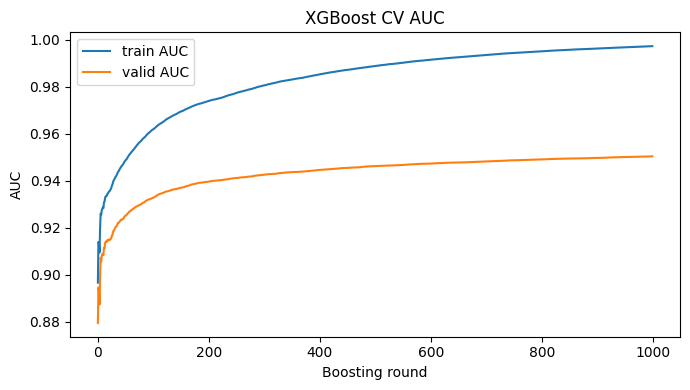


Fitting final model on training data...
[0]	validation_0-auc:0.89558	validation_1-auc:0.88381
[1]	validation_0-auc:0.91238	validation_1-auc:0.89788
[2]	validation_0-auc:0.91132	validation_1-auc:0.89528
[3]	validation_0-auc:0.90703	validation_1-auc:0.88966
[4]	validation_0-auc:0.91776	validation_1-auc:0.90305
[5]	validation_0-auc:0.92393	validation_1-auc:0.91107
[6]	validation_0-auc:0.92319	validation_1-auc:0.90915
[7]	validation_0-auc:0.92512	validation_1-auc:0.91163
[8]	validation_0-auc:0.92589	validation_1-auc:0.91287
[9]	validation_0-auc:0.92664	validation_1-auc:0.91302
[10]	validation_0-auc:0.92627	validation_1-auc:0.91251
[11]	validation_0-auc:0.92870	validation_1-auc:0.91574
[12]	validation_0-auc:0.92883	validation_1-auc:0.91533
[13]	validation_0-auc:0.93071	validation_1-auc:0.91761
[14]	validation_0-auc:0.93121	validation_1-auc:0.91826
[15]	validation_0-auc:0.93135	validation_1-auc:0.91842
[16]	validation_0-auc:0.93142	validation_1-auc:0.91816
[17]	validation_0-auc:0.93217	vali

/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [11:31:49] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



=== Model Report (TRAIN) ===
Accuracy : 0.9723
AUC      : 0.9959

=== Model Report (VALID) ===
Accuracy : 0.9029
AUC      : 0.9579


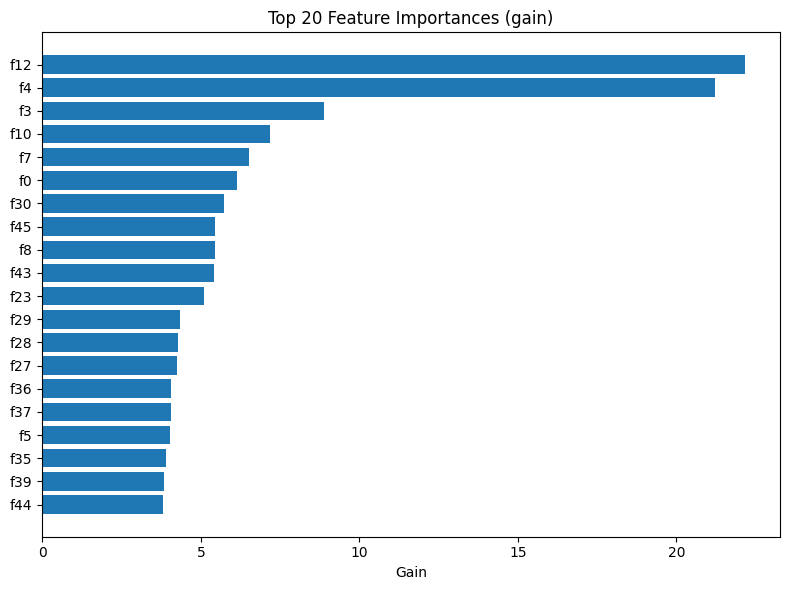


========== FOLD 2 / 5 ==========
Starting cross-validation with early stopping...
[0]	train-auc:0.89750+0.00077	test-auc:0.88122+0.00220
[1]	train-auc:0.91455+0.00045	test-auc:0.89699+0.00148
[2]	train-auc:0.91326+0.00039	test-auc:0.89420+0.00198
[3]	train-auc:0.90966+0.00034	test-auc:0.88883+0.00183
[4]	train-auc:0.91993+0.00042	test-auc:0.90087+0.00192
[5]	train-auc:0.92626+0.00044	test-auc:0.90851+0.00175
[6]	train-auc:0.92576+0.00046	test-auc:0.90689+0.00160
[7]	train-auc:0.92755+0.00039	test-auc:0.90920+0.00161
[8]	train-auc:0.92813+0.00035	test-auc:0.91010+0.00169
[9]	train-auc:0.92890+0.00035	test-auc:0.91013+0.00161
[10]	train-auc:0.92866+0.00039	test-auc:0.90962+0.00160
[11]	train-auc:0.93119+0.00039	test-auc:0.91277+0.00159
[12]	train-auc:0.93135+0.00038	test-auc:0.91241+0.00154
[13]	train-auc:0.93300+0.00033	test-auc:0.91450+0.00161
[14]	train-auc:0.93360+0.00035	test-auc:0.91522+0.00165
[15]	train-auc:0.93380+0.00036	test-auc:0.91531+0.00169
[16]	train-auc:0.93391+0.00035	

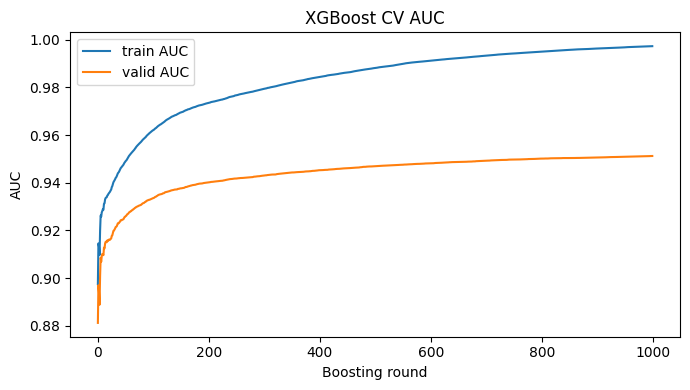


Fitting final model on training data...
[0]	validation_0-auc:0.89613	validation_1-auc:0.88216
[1]	validation_0-auc:0.91304	validation_1-auc:0.89633
[2]	validation_0-auc:0.91175	validation_1-auc:0.89400
[3]	validation_0-auc:0.90754	validation_1-auc:0.88830
[4]	validation_0-auc:0.91785	validation_1-auc:0.90072
[5]	validation_0-auc:0.92431	validation_1-auc:0.90808
[6]	validation_0-auc:0.92365	validation_1-auc:0.90641
[7]	validation_0-auc:0.92559	validation_1-auc:0.90866
[8]	validation_0-auc:0.92628	validation_1-auc:0.90961
[9]	validation_0-auc:0.92689	validation_1-auc:0.90949
[10]	validation_0-auc:0.92661	validation_1-auc:0.90892
[11]	validation_0-auc:0.92913	validation_1-auc:0.91212
[12]	validation_0-auc:0.92921	validation_1-auc:0.91168
[13]	validation_0-auc:0.93095	validation_1-auc:0.91383
[14]	validation_0-auc:0.93154	validation_1-auc:0.91453
[15]	validation_0-auc:0.93167	validation_1-auc:0.91465
[16]	validation_0-auc:0.93171	validation_1-auc:0.91445
[17]	validation_0-auc:0.93234	vali

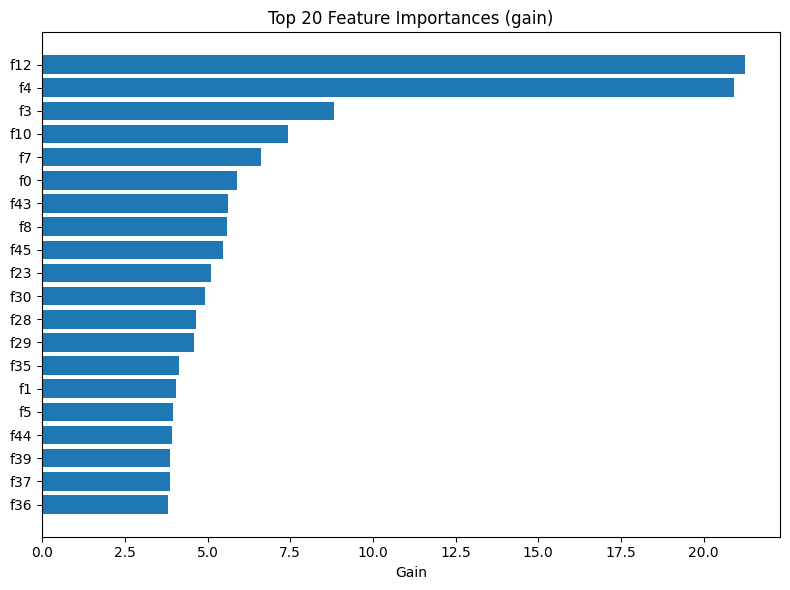


========== FOLD 3 / 5 ==========
Starting cross-validation with early stopping...
[0]	train-auc:0.89734+0.00027	test-auc:0.88034+0.00212
[1]	train-auc:0.91458+0.00052	test-auc:0.89596+0.00180
[2]	train-auc:0.91325+0.00068	test-auc:0.89343+0.00188
[3]	train-auc:0.90968+0.00063	test-auc:0.88809+0.00186
[4]	train-auc:0.92001+0.00045	test-auc:0.90028+0.00184
[5]	train-auc:0.92614+0.00036	test-auc:0.90775+0.00197
[6]	train-auc:0.92563+0.00041	test-auc:0.90624+0.00188
[7]	train-auc:0.92757+0.00046	test-auc:0.90854+0.00173
[8]	train-auc:0.92830+0.00043	test-auc:0.90963+0.00168
[9]	train-auc:0.92894+0.00034	test-auc:0.90961+0.00177
[10]	train-auc:0.92862+0.00036	test-auc:0.90897+0.00188
[11]	train-auc:0.93108+0.00035	test-auc:0.91201+0.00194
[12]	train-auc:0.93122+0.00030	test-auc:0.91166+0.00199
[13]	train-auc:0.93296+0.00032	test-auc:0.91389+0.00207
[14]	train-auc:0.93352+0.00035	test-auc:0.91461+0.00199
[15]	train-auc:0.93378+0.00034	test-auc:0.91472+0.00192
[16]	train-auc:0.93389+0.00032	

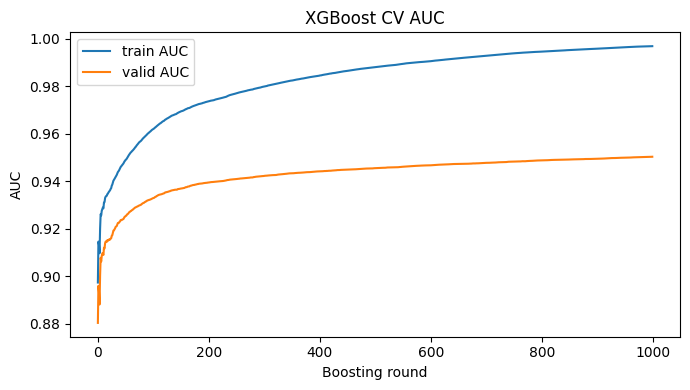


Fitting final model on training data...
[0]	validation_0-auc:0.89621	validation_1-auc:0.88345
[1]	validation_0-auc:0.91313	validation_1-auc:0.89681
[2]	validation_0-auc:0.91109	validation_1-auc:0.89421
[3]	validation_0-auc:0.90709	validation_1-auc:0.88888
[4]	validation_0-auc:0.91778	validation_1-auc:0.90148
[5]	validation_0-auc:0.92412	validation_1-auc:0.90908
[6]	validation_0-auc:0.92347	validation_1-auc:0.90777
[7]	validation_0-auc:0.92556	validation_1-auc:0.91025
[8]	validation_0-auc:0.92621	validation_1-auc:0.91104
[9]	validation_0-auc:0.92692	validation_1-auc:0.91110
[10]	validation_0-auc:0.92659	validation_1-auc:0.91059
[11]	validation_0-auc:0.92931	validation_1-auc:0.91384
[12]	validation_0-auc:0.92942	validation_1-auc:0.91338
[13]	validation_0-auc:0.93125	validation_1-auc:0.91559
[14]	validation_0-auc:0.93193	validation_1-auc:0.91634
[15]	validation_0-auc:0.93218	validation_1-auc:0.91647
[16]	validation_0-auc:0.93224	validation_1-auc:0.91613
[17]	validation_0-auc:0.93297	vali

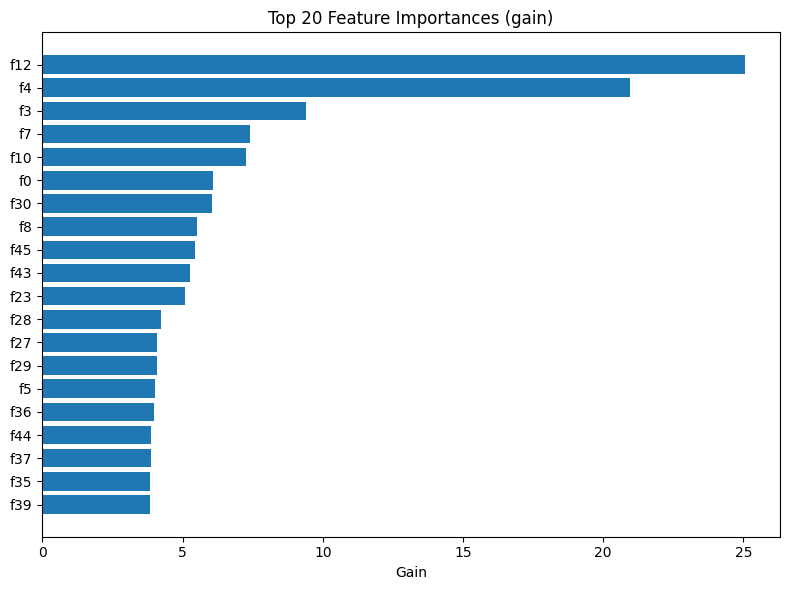


========== FOLD 4 / 5 ==========
Starting cross-validation with early stopping...
[0]	train-auc:0.89760+0.00057	test-auc:0.88057+0.00064
[1]	train-auc:0.91484+0.00056	test-auc:0.89641+0.00131
[2]	train-auc:0.91349+0.00047	test-auc:0.89374+0.00107
[3]	train-auc:0.91000+0.00039	test-auc:0.88861+0.00111
[4]	train-auc:0.92049+0.00039	test-auc:0.90114+0.00109
[5]	train-auc:0.92654+0.00031	test-auc:0.90857+0.00113
[6]	train-auc:0.92609+0.00028	test-auc:0.90697+0.00107
[7]	train-auc:0.92797+0.00027	test-auc:0.90921+0.00107
[8]	train-auc:0.92863+0.00029	test-auc:0.91014+0.00114
[9]	train-auc:0.92919+0.00022	test-auc:0.91002+0.00117
[10]	train-auc:0.92897+0.00024	test-auc:0.90952+0.00131
[11]	train-auc:0.93145+0.00034	test-auc:0.91267+0.00126
[12]	train-auc:0.93159+0.00037	test-auc:0.91231+0.00120
[13]	train-auc:0.93339+0.00033	test-auc:0.91454+0.00117
[14]	train-auc:0.93399+0.00032	test-auc:0.91526+0.00112
[15]	train-auc:0.93426+0.00035	test-auc:0.91548+0.00108
[16]	train-auc:0.93434+0.00038	

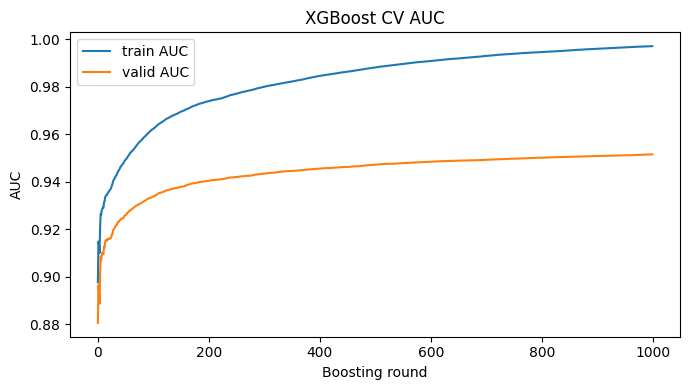


Fitting final model on training data...
[0]	validation_0-auc:0.89709	validation_1-auc:0.88051
[1]	validation_0-auc:0.91373	validation_1-auc:0.89658
[2]	validation_0-auc:0.91248	validation_1-auc:0.89511
[3]	validation_0-auc:0.90881	validation_1-auc:0.88976
[4]	validation_0-auc:0.91943	validation_1-auc:0.90175
[5]	validation_0-auc:0.92562	validation_1-auc:0.90888
[6]	validation_0-auc:0.92480	validation_1-auc:0.90759
[7]	validation_0-auc:0.92655	validation_1-auc:0.90950
[8]	validation_0-auc:0.92707	validation_1-auc:0.91021
[9]	validation_0-auc:0.92750	validation_1-auc:0.91033
[10]	validation_0-auc:0.92723	validation_1-auc:0.91007
[11]	validation_0-auc:0.92986	validation_1-auc:0.91309
[12]	validation_0-auc:0.92986	validation_1-auc:0.91282
[13]	validation_0-auc:0.93159	validation_1-auc:0.91474
[14]	validation_0-auc:0.93223	validation_1-auc:0.91532
[15]	validation_0-auc:0.93245	validation_1-auc:0.91543
[16]	validation_0-auc:0.93248	validation_1-auc:0.91513
[17]	validation_0-auc:0.93317	vali

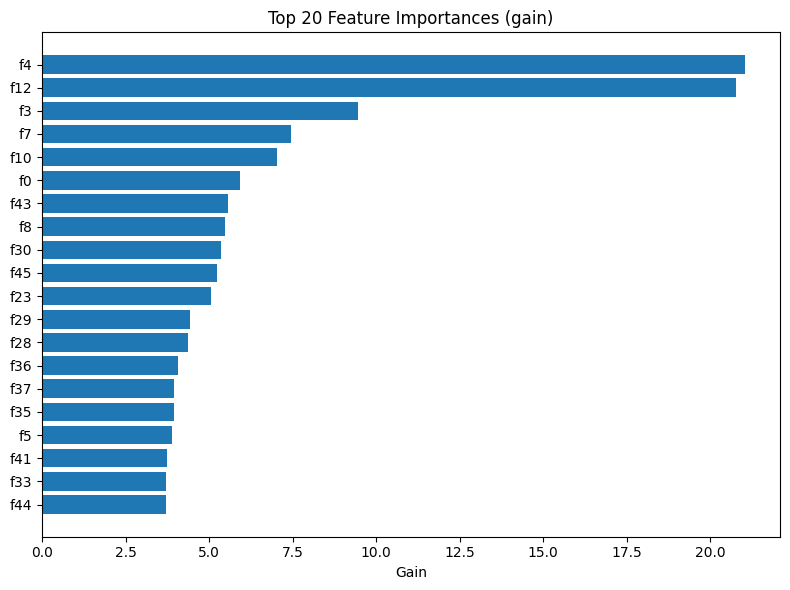


========== FOLD 5 / 5 ==========
Starting cross-validation with early stopping...
[0]	train-auc:0.89756+0.00054	test-auc:0.87969+0.00058
[1]	train-auc:0.91513+0.00042	test-auc:0.89492+0.00109
[2]	train-auc:0.91432+0.00045	test-auc:0.89292+0.00134
[3]	train-auc:0.91086+0.00052	test-auc:0.88795+0.00120
[4]	train-auc:0.92103+0.00047	test-auc:0.90009+0.00093
[5]	train-auc:0.92686+0.00037	test-auc:0.90753+0.00043
[6]	train-auc:0.92636+0.00033	test-auc:0.90605+0.00057
[7]	train-auc:0.92826+0.00032	test-auc:0.90831+0.00035
[8]	train-auc:0.92874+0.00030	test-auc:0.90927+0.00021
[9]	train-auc:0.92940+0.00037	test-auc:0.90926+0.00025
[10]	train-auc:0.92918+0.00031	test-auc:0.90878+0.00042
[11]	train-auc:0.93156+0.00028	test-auc:0.91193+0.00033
[12]	train-auc:0.93171+0.00029	test-auc:0.91160+0.00037
[13]	train-auc:0.93336+0.00030	test-auc:0.91368+0.00026
[14]	train-auc:0.93391+0.00028	test-auc:0.91437+0.00027
[15]	train-auc:0.93415+0.00027	test-auc:0.91453+0.00027
[16]	train-auc:0.93426+0.00028	

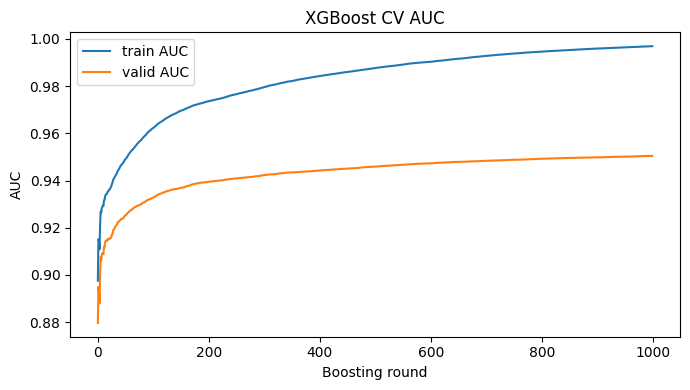


Fitting final model on training data...
[0]	validation_0-auc:0.89651	validation_1-auc:0.87927
[1]	validation_0-auc:0.91372	validation_1-auc:0.89579
[2]	validation_0-auc:0.91234	validation_1-auc:0.89329
[3]	validation_0-auc:0.90856	validation_1-auc:0.88811
[4]	validation_0-auc:0.91907	validation_1-auc:0.90018
[5]	validation_0-auc:0.92502	validation_1-auc:0.90787
[6]	validation_0-auc:0.92450	validation_1-auc:0.90616
[7]	validation_0-auc:0.92635	validation_1-auc:0.90835
[8]	validation_0-auc:0.92677	validation_1-auc:0.90918
[9]	validation_0-auc:0.92728	validation_1-auc:0.90915
[10]	validation_0-auc:0.92695	validation_1-auc:0.90879
[11]	validation_0-auc:0.92934	validation_1-auc:0.91184
[12]	validation_0-auc:0.92948	validation_1-auc:0.91148
[13]	validation_0-auc:0.93120	validation_1-auc:0.91369
[14]	validation_0-auc:0.93175	validation_1-auc:0.91454
[15]	validation_0-auc:0.93196	validation_1-auc:0.91479
[16]	validation_0-auc:0.93201	validation_1-auc:0.91459
[17]	validation_0-auc:0.93275	vali

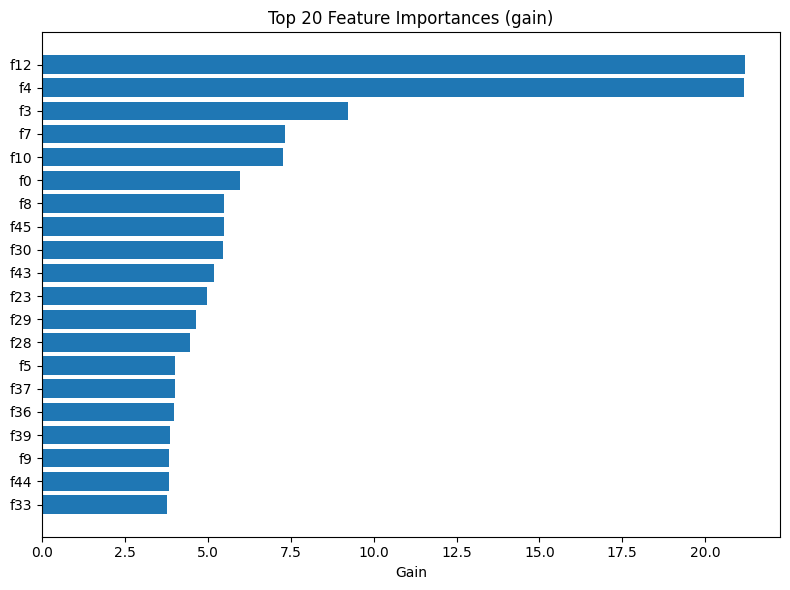


===== XGBoost OOF performance =====
OOF AUC: 0.9558392179991214


In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

for fold, (train_idx, val_idx) in enumerate(skf.split(X_meta_all, y_all)):
    print(f"\n========== FOLD {fold + 1} / {N_SPLITS} ==========")

    # Split metadata
    X_tr, X_val = X_meta_all[train_idx], X_meta_all[val_idx]
    y_tr, y_val = y_all[train_idx], y_all[val_idx]

    # Fresh model for this fold
    xgb_model = XGBClassifier(**xgb_base_params)

    # Use your modelfit to tune n_estimators on this fold + train
    xgb_model = modelfit(
        xgb_model,
        X_train=X_tr,
        y_train=y_tr,
        X_valid=X_val,
        y_valid=y_val,
        useTrainCV=True,
        cv_folds=5,
        early_stopping_rounds=50,
    )

    # --- OOF for this fold ---
    val_proba = xgb_model.predict_proba(X_val)[:, 1]
    oof_xgb[val_idx] = val_proba

    # --- Test preds for this fold ---
    test_proba = xgb_model.predict_proba(X_meta_test)[:, 1]
    test_pred_xgb[:, fold] = test_proba

    

# After all folds: global OOF metric
print("\n===== XGBoost OOF performance =====")
print("OOF AUC:", roc_auc_score(y_all, oof_xgb))

# This is what you'll use later for stacking:
xgb_test_mean = test_pred_xgb.mean(axis=1)  # fold-averaged test proba


In [ ]:
oof_cam = np.zeros(len(df), dtype=float)
test_pred_cam = np.zeros((len(df_test), N_SPLITS), dtype=float)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_text_all, y_all)):
    print(f"\n========== CamemBERT FOLD {fold + 1} / {N_SPLITS} ==========")

    texts_tr = X_text_all[train_idx]
    texts_val = X_text_all[val_idx]
    y_tr = y_all[train_idx]
    y_val = y_all[val_idx]

    # Train + get preds for this fold
    val_probs, test_probs = train_camembert_one_fold(
        texts_tr, y_tr,
        texts_val, y_val,
        X_text_test,
        epochs=2,         # you can increase later
        batch_size=16,
        lr=2e-5,
        max_len=128
    )

    oof_cam[val_idx] = val_probs
    test_pred_cam[:, fold] = test_probs

from sklearn.metrics import roc_auc_score
print("\n===== CamemBERT OOF performance =====")
print("OOF AUC:", roc_auc_score(y_all, oof_cam))

cam_test_mean = test_pred_cam.mean(axis=1)  # mean over folds


In [ ]:
import os
import numpy as np
import pandas as pd  # you already have this

out_dir = "oof_outputs"
os.makedirs(out_dir, exist_ok=True)

# Mean over folds for test
xgb_test_mean = test_pred_xgb.mean(axis=1)
cam_test_mean = test_pred_cam.mean(axis=1)

# ------- 1) Save as .npy (fast & safe) -------
np.save(os.path.join(out_dir, "oof_xgb.npy"), oof_xgb)
np.save(os.path.join(out_dir, "test_pred_xgb.npy"), test_pred_xgb)

np.save(os.path.join(out_dir, "oof_cam.npy"), oof_cam)
np.save(os.path.join(out_dir, "test_pred_cam.npy"), test_pred_cam)

np.save(os.path.join(out_dir, "xgb_test_mean.npy"), xgb_test_mean)
np.save(os.path.join(out_dir, "cam_test_mean.npy"), cam_test_mean)

print("Saved .npy files in", out_dir)


In [ ]:
ID_COL = "ID"  # change if your id column is named differently

# OOF per train row
df_oof = pd.DataFrame({
    ID_COL: df[ID_COL].values,
    "label": y_all,
    "oof_xgb": oof_xgb,
    "oof_cam": oof_cam,
})
df_oof.to_csv(os.path.join(out_dir, "oof_train.csv"), index=False)

# Test preds per test row (mean over folds)
df_test_preds = pd.DataFrame({
    ID_COL: df_test[ID_COL].values,
    "xgb_mean": xgb_test_mean,
    "cam_mean": cam_test_mean,
})
df_test_preds.to_csv(os.path.join(out_dir, "test_preds.csv"), index=False)

print("Saved CSVs in", out_dir)
